   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
   sepal_length  sepal_width  petal_length  petal_width
0      1.170020     0.435890     -0.527656    -1.078254
1      1.239598     0.306831     -0.478657    -1.067773
2      1.176472     0.425532     -0.525657    -1.076346
3      1.176630     0.392210     -0.444505    -1.124335
4      1.136160     0.486926     -0.533300    -1.089786


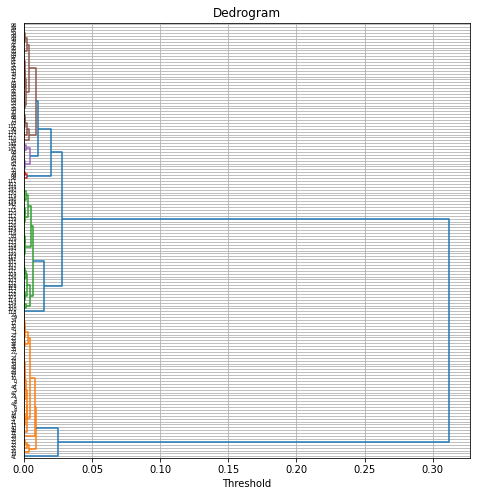

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
import pandas as pd

# Irisデータの読み込み
df = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')
print(df.head())

# 縦方向に正規化(標準スコア化)、欠損情報があれば 0.0 埋め
# そうしないと、項目ごとに値の幅が違うため、"距離" を計算するときに項目の重みが変わってしまう
# (データの特性によっては、あえて正規化しないという方法もありうる)
dfs = df.iloc[:, 0:4].apply(lambda x: (x-x.mean())/x.std(), axis=1).fillna(0)
print(dfs.head())

result1 = linkage(dfs, 
                  #metric = 'braycurtis', 
                  #metric = 'canberra', 
                  #metric = 'chebyshev', 
                  #metric = 'cityblock', 
                  metric = 'correlation', 
                  #metric = 'cosine', 
                  #metric = 'euclidean', 
                  #metric = 'hamming', 
                  #metric = 'jaccard', 
                  #method= 'single')
                  method = 'average')
                  #method= 'complete')
                  #method='weighted')
plt.figure(figsize=(8, 8))
dendrogram(result1, orientation='right', labels=list(df.index), color_threshold=0.01)
plt.title("Dedrogram")
plt.xlabel("Threshold")
plt.grid()
plt.show()

# result1 の構造
* 12  と　34 を合わせて グループ151 を作った (要素数2)
* 101 と 142 を合わせて グループ152 を作った (要素数2)
* ...
* 41  と　グループ291 を合わせて グループ296 を作った (要素数50)
* グループ294  と　グループ295 を合わせて グループ297 を作った (要素数100)
* グループ296  と　グループ297 を合わせて グループ298 を作った (要素数150)

In [2]:
print(len(df))
pd.DataFrame(result1)

150


,0,1,2,3
0,12.0,34.0,0.000000,2.0
1,101.0,142.0,0.000000,2.0
2,56.0,96.0,0.000003,2.0
3,35.0,36.0,0.000003,2.0
4,105.0,128.0,0.000007,2.0
...,...,...,...,...
144,118.0,289.0,0.014782,46.0
145,275.0,293.0,0.019599,54.0
146,41.0,291.0,0.025156,50.0
147,294.0,295.0,0.028111,100.0


# 結果の Dedrogram から、3グループを作る

In [3]:
from scipy.cluster.hierarchy import fcluster
import numpy as np

clusters = fcluster(result1, t=3, criterion='maxclust')

np1 = np.array(clusters)
np2 = df.iloc[:,4].to_numpy()

resultpd = pd.DataFrame(np.vstack((np1, np2)).T, columns=["cluster", "name"])
resultpd

,cluster,name
0,1,setosa
1,1,setosa
2,1,setosa
3,1,setosa
4,1,setosa
...,...,...
145,3,virginica
146,2,virginica
147,2,virginica
148,2,virginica


* 結構うまく行っとる
    * グループ1 setosa  (50件中、件誤検知なし、取りこぼしなし)
    * グループ3 versicolor (50件中、2件誤検知、6件取りこぼし)
    * グループ2 virginica (50件中、6件誤検知、2件取りこぼし)

In [4]:
matrix = list()
for n in set(resultpd['name']):
    ary = list()
    for c in set(resultpd['cluster']):
        query = 'name == "' + n + '" & cluster == ' + str(c)
        ary.append(len (resultpd.query(query)))
    
    matrix.append(ary)

pd.DataFrame(matrix, index=set(resultpd['name']), columns=set(resultpd['cluster']))

,1,2,3
setosa,50,0,0
versicolor,0,2,48
virginica,0,44,6


# 結果の Dedrogram から、距離のしきい値 0.01 でグループ分けする

In [6]:
clusters2 = fcluster(result1, 0.01, criterion='distance')

np3 = np.array(clusters2)

resultPd2 = pd.DataFrame(np.vstack((np3, np2)).T, columns=["cluster", "name"])
resultPd2

,cluster,name
0,1,setosa
1,1,setosa
2,1,setosa
3,1,setosa
4,1,setosa
...,...,...
145,6,virginica
146,3,virginica
147,3,virginica
148,3,virginica


7グループに別れた

In [11]:
matrix = list()
for n in set(resultPd2['name']):
    ary = list()
    for c in set(resultPd2['cluster']):
        query = 'name == "' + n + '" & cluster == ' + str(c)
        ary.append(len (resultPd2.query(query)))
    
    matrix.append(ary)

pd.DataFrame(matrix, index=set(resultPd2['name']), columns=set(resultPd2['cluster']))

,1,2,3,4,5,6,7
setosa,49,1,0,0,0,0,0
versicolor,0,0,2,0,3,8,37
virginica,0,0,43,1,0,2,4
